In [ ]:
!pip install transformers

In [ ]:
import tensorflow as tf
import json
import pandas as pd
import numpy as np
import os
import torch as t
import datetime
import transformers
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification") ## device = 0 forces it to use GPU

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/MyDrive/datax/zero_shot_test")
!ls

Mounted at /content/drive/
all_labelled_w_stars.xlsx
zero_shot_model_test_02_picking_a_threshold.ipynb
zero_shot_model_test_03_apply_labels_on_rev.ipynb
zero_shot_model_test.ipynb


In [ ]:
#Inputs
#df: dataframe with reviews (column name with reviews should be "text")
#tags: the tags you want to find in the reviews (Eg : ['expensive','costly','not worth the price'])
def zsl_processor(df, tags):
  
  summary_label = pd.DataFrame()

  for i in range(len(df)):
    rev_id = df['review_id'][i]
    msg = df['text'][i]
    bid = df['business_id'][i]
    result = classifier(msg, tags, multi_label=True)
    df_results = pd.DataFrame(result)
    
    for j in range(len(tags)):
      temp_rev_label = pd.DataFrame({
          'business_id':[bid], 
          'review_id':[rev_id], 
          'text':[msg], 
          'label':[df_results.labels[j]], 
          'score':[df_results.scores[j]],
          })
      
      summary_label = summary_label.append(temp_rev_label)

  return summary_label

In [ ]:
test_df = pd.read_excel('all_labelled_w_stars.xlsx')

In [ ]:
expensive = ["expensive"]
bad_customer_service = ["bad customer service", "long wait time", "unfriendly"]
bad_ambience = ["bad ambience", "dirty", "crowded"]
small_portion = ["small portion"]
poor_food_quality = ["bad food taste", "overcooked", "undercooked", "bad drinks"]
all_categoty = expensive + bad_customer_service + bad_ambience + small_portion + poor_food_quality

In [ ]:
start = datetime.datetime.now()
test = zsl_processor(test_df, expensive) ## DONT FORGET TO CHANGE THIS 
test = test.reset_index(drop=True)
time_elapsed = datetime.datetime.now()
print('Length:', len(test_df), ",    time elapsed:", time_elapsed)

In [ ]:
def thresholder_category(df, tags, category, threshold=0.5):
  df_final = df.copy()
  df['flag'] = np.where(df['score'] >= threshold, 1, 0)
  df_tags_interest = df[df['label'].isin(tags)]
  df_revs_positive_cat = df_tags_interest[df_tags_interest['flag'] == 1]
  df_final.drop_duplicates(['review_id'], inplace=True)
  df_final[category] = np.where(df_final['review_id'].isin(df_revs_positive_cat['review_id']), 1, 0)
  return df_final[['review_id', 'business_id', category]]

In [ ]:
test_02 = thresholder_category(test, ["expensive"], 'expensive', threshold=0.96)

In [ ]:
def prediction_accuracy(df_predict, df_label, label):
  df_predict.rename(columns={label:'Predict'}, inplace=True)
  df_label.rename(columns={label:'Test'}, inplace=True)
  y_pred_test = df_predict.merge(df_label, on=['review_id', 'business_id'], how='inner')
  tp=sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 1))
  tn=sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 0))
  fp=sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 1))
  fn=sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 0))
  #TPR, FPR, Accuracy
  TPR = tp/(tp+fn)
  FPR = fp/(fp+tn)
  accuracy = (tp+tn)/(tn+tp+fn+fp)
  # print(model_type, " :")
  print("TPR: ", round(TPR,4))
  print("FPR: ", round(FPR,4))
  print("Accuracy: ", round(accuracy,4))
  # return TPR, FPR, accuracy, 
  return y_pred_test

In [ ]:
check = prediction_accuracy(test_02, test_df, "expensive")

TPR:  0.7778
FPR:  0.0399
Accuracy:  0.947


In [ ]:
check2 = check[(check['Test'] != check['Predict']) & (check['Test'] == 0)]

In [ ]:
check2.text.iloc[61]

'I use the drive thru to order a small sized French fries. The guy misunderstood us and give us a sprite instead. I were surprised that they give free drinks for ordering only a fries, but later realized they missed our order. The guy was update before I can him for correcting the mistake. \n\nBad experience. Will not recommend if you just want to save time and order a quick meal.'

In [ ]:
def prediction_accuracy_2(df_predict,df_label, label):
  df_predict.rename(columns={label:'Predict'}, inplace=True)
  df_label.rename(columns={label:'Test'}, inplace=True)
  y_pred_test=df_predict.merge(df_label, on=['review_id', 'business_id'], how='inner')
  tp = sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 1))
  tn = sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 0))
  fp = sum((y_pred_test['Test'] == 0) & (y_pred_test['Predict'] == 1))
  fn = sum((y_pred_test['Test'] == 1) & (y_pred_test['Predict'] == 0))
  #TPR, FPR, Accuracy
  TPR = tp/(tp+fn)
  FPR = fp/(fp+tn)
  accuracy = (tp+tn)/(tn+tp+fn+fp)
  #Precision, recall
  pr=tp/(tp+fp)
  rc=tp/(tp+fn)
  # # print(model_type, " :")
  # print("TPR: ", round(TPR,4))
  # print("FPR: ", round(FPR,4))
  # print("Precision: ", round(pr,4))
  # print("Recall: ", round(rc,4))
  # print("Accuracy: ", round(accuracy,4))
  return TPR, FPR, pr, rc, accuracy

In [ ]:
tpr,fpr,pc,rc,accuracy=prediction_accuracy_2(test_02, test_df, "expensive")

In [ ]:
## plotting pr vs. re
import matplotlib.pyplot as plt
#Note:df is the dataset with all the reviews that need tagging
def plotter_roc(df,df_label,tags,label):
  summary_plot=pd.DataFrame()
  for t in np.arange(0, 1, 0.01):
    df_predict_t=thresholder_category(df, tags, label, t)
    tpr,fpr,pr,rc,accuracy=prediction_accuracy_2(df_predict_t, df_label, label)
    plot_temp=pd.DataFrame({'Threshold':[t], 'Precision':[pr], 'Recall':[rc]})
    summary_plot=summary_plot.append(plot_temp)
  return summary_plot

In [ ]:
summaryplot_df = plotter_roc(test, test_df, ["expensive"], 'expensive')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
summaryplot_df=summaryplot_df.reset_index(drop=True)

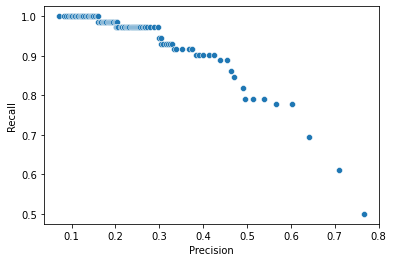

In [ ]:
import seaborn as sns
sns.scatterplot(data=summaryplot_df, x="Precision", y="Recall")

In [ ]:
# Pick 0.96 for threshold.